<a href="https://colab.research.google.com/github/veiro/tesis-imputacion-datos/blob/main/codigo/metricas/coseno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Similiridad semantica, similutd del coseno
- el objetivo es ver que tan similares son semanticamente las tuplas utilizadas en la tarea de prediccion


# Configuracion

In [ ]:
USAR_GOOGLE_DRIVE =  True
MODO_DESARROLLO = False



In [ ]:
!pip install "pandas<2.0.0"
!pip install "joblib==1.3.2"
!pip install "scikit-learn==1-4-2"

ERROR: Could not find a version that satisfies the requirement scikit-learn==1-4-2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2, 1.4.0rc1, 1.4.0, 1.4.1.post1, 1.4.2, 1.5.0rc1, 1.5.0)
ERROR: No matching distribution found for scikit-learn==1-4-2


In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity



#Descarga de datos y preprocesamiento





In [ ]:
%%time
if (USAR_GOOGLE_DRIVE):
  drive.mount('/content/gdrive')
  PATH_DATA_PROCESADA = "/content/gdrive/MyDrive/Maestria/Tesis/Codigo/data/data-procesada"
  sys.path.append('/content/gdrive/MyDrive/Maestria/Tesis/Codigo/utils')

else:
  PATH_DATA_PROCESADA = "/mnt"


import utils as utils
import importlib
importlib.reload(utils)

if (30 ==  utils.version()):
  print("version correcta")
else:
  raise Exception("Version de Util vieja")

data_full = pd.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=False_missing=False_' + 'Desarrollo=False' + '.csv')


data_sin_null = data_full.dropna(subset=['Province_State', 'Lat', 'Long_', 'Incident_Rate', 'Case_Fatality_Ratio'])

if(MODO_DESARROLLO):
   data_utilizar = data_sin_null.sample(n=10000, random_state=1)
else:
  data_utilizar = data_sin_null

df_test_encoded, df_test_encoded_missing, mask_test_open = utils.obtenerDatosTest(MODO_DESARROLLO, PATH_DATA_PROCESADA)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
version correcta
CPU times: user 8.22 s, sys: 782 ms, total: 9 s
Wall time: 12.2 s


# Utils

In [ ]:
df_resultados = pd.DataFrame(columns=['Strategy', 'sim_coseno_promedio' ])

def guardoResultados(strat, sim_coseno_promedio):
  global df_resultados
  print("Strategy: " + utils.prettyPrintName(strat) + ' - sim_coseno_promedio: ' + str(sim_coseno_promedio) )
  df_resultados = pd.concat([df_resultados , pd.DataFrame([{ 'Strategy':utils.prettyPrintName(strat),'sim_coseno_promedio':sim_coseno_promedio}])])

def calcularMetricas(data, imputed_data, strat):

  data, imputed_data  = utils.obtener_df_imputados(data, imputed_data, mask_test_open)

  imputed_data.to_csv(PATH_DATA_PROCESADA+'/cod_imp_'+strat, index=False)
  sim_coseno_promedio = utils.calcular_similitud_cosine_promedio(data, imputed_data)
  guardoResultados(strat, sim_coseno_promedio)

In [ ]:
# el tema es que el encoding ya guardaba cosas, entocnes me traje el codigo y lo modifique para codificar nomas.
def encoding(dataset, PATH_DATA_PROCESADA):
  global encoderOHE
  global encoderLE1
  global encoderLE2
  global encoderLE3
  global encoded_df_Country_Region_cols

  # ENCODING
  # 1- onehotenconding de Country_Region
  df=dataset

  encoded_data = encoderOHE.fit_transform( df[['Country_Region']])
  encoded_df_Country_Region = pd.DataFrame(encoded_data, columns=encoderOHE.get_feature_names_out(['Country_Region']))
  encoded_df_Country_Region_cols = encoded_df_Country_Region.shape[1]

  df = df.drop(['Country_Region'], axis=1)

  # hice este concat horrible por que por alguna razon no me andaba bien el concant ordinario
  pos = encoded_df_Country_Region_cols
  for col in df.columns:
    encoded_df_Country_Region.insert( pos, col, df[col].to_numpy(), True)
    pos=pos+1

  df = encoded_df_Country_Region

  # 2 Province_State, Last_Update, date
  df['Province_State_encoded'] = encoderLE1.fit_transform(df['Province_State'])
  df = df.drop(['Province_State'], axis=1)

  df['Last_Update_encoded'] = encoderLE2.fit_transform(df['Last_Update'])
  df = df.drop(['Last_Update'], axis=1)

  df['date_encoded'] = encoderLE3.fit_transform(df['date'])
  df = df.drop(['date'], axis=1)

  df.reset_index(drop=True)

  # guardo los modelos utilizados:
  #save_pickle_model('encoderOHE',encoderOHE, PATH_DATA_PROCESADA )
  #save_pickle_model('encoderLE1',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoderLE2',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoderLE3',encoderLE1, PATH_DATA_PROCESADA)
  #save_pickle_model('encoded_df_Country_Region_cols',encoderLE1, PATH_DATA_PROCESADA)
  return df

import pickle
def save_pickle_model(name, model, PATH_DATA_PROCESADA):
 with open(PATH_DATA_PROCESADA + '/' + name , 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle_model(name, PATH_DATA_PROCESADA):
  with open(PATH_DATA_PROCESADA + '/' + name, 'rb') as handle:
      model = pickle.load(handle)
  return model
  # variables gloables
encoded_df_Country_Region_cols = 0
encoderOHE = OneHotEncoder(handle_unknown='ignore')
encoderLE1 = LabelEncoder()
encoderLE2 = LabelEncoder()
encoderLE3 = LabelEncoder()



encoderOHE = load_pickle_model('encoderOHE', PATH_DATA_PROCESADA)
encoderLE1 = load_pickle_model('encoderLE1', PATH_DATA_PROCESADA)
encoderLE2 = load_pickle_model('encoderLE2', PATH_DATA_PROCESADA)
encoderLE3 = load_pickle_model('encoderLE3', PATH_DATA_PROCESADA)
encoded_df_Country_Region_cols = load_pickle_model('encoded_df_Country_Region_cols', PATH_DATA_PROCESADA)

# calcular similtudes coseno con la codificacion de pycaret para prediccion numerico



In [ ]:
files=[
       'csse_covid_19_data_strategy=constant_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=most_frequent_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=mean_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=median_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_strategy=IterativeImputer_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_MIDASpy_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_GAIN._Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_Transformer_final_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_XGBoost_full_Desarrollo='+str(MODO_DESARROLLO)+'.csv',
       'csse_covid_19_data_Knn_full_Desarrollo='+str(MODO_DESARROLLO)+'.csv']




#ruta_modelo = PATH_DATA_PROCESADA + '/modelo_prediccion/' + 'regresion_deaths_Desarrollo=False'
#loaded_best_pipeline = load_model(ruta_modelo)
#s = setup(data_utilizar, target = 'Deaths', session_id = 123, verbose = False)
#prep_pipe = get_config('pipeline')
#data_original_encoded =  prep_pipe.transform(data_utilizar)

data_original_encoded =  encoding(data_utilizar, PATH_DATA_PROCESADA).reset_index(drop=True)
## esto es por que debo comprar misma dimension
if(MODO_DESARROLLO):
  data_original_encoded =  data_original_encoded.sample(n=10000, random_state=1,replace=True)



In [ ]:
for fp in  files:
  print("Inicio " + fp)
  data_imputed_full = pd.read_csv(PATH_DATA_PROCESADA+'/'+fp)
  if(MODO_DESARROLLO):
    data_imputed =  data_imputed_full.sample(n=10000, random_state=1,replace=True ).reset_index(drop=True)
  else:
    data_imputed = data_imputed_full


  #data_imputed_encoded = prep_pipe.transform(data_imputed)
  data_imputed_encoded = encoding(data_imputed, PATH_DATA_PROCESADA).reset_index(drop=True)

  calcularMetricas(data_original_encoded, data_imputed_encoded, fp)

  del data_imputed_encoded
  del data_imputed_full
  del data_imputed

  print("Fin  " + fp)
  print("-----------------------------------")

Inicio csse_covid_19_data_strategy=constant_Desarrollo=False.csv
Strategy: constant - sim_coseno_promedio: 0.8109686209525381
Fin  csse_covid_19_data_strategy=constant_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=most_frequent_Desarrollo=False.csv
Strategy: most_frequent - sim_coseno_promedio: 0.810974458744135
Fin  csse_covid_19_data_strategy=most_frequent_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=mean_Desarrollo=False.csv
Strategy: mean - sim_coseno_promedio: 0.9706482267310518
Fin  csse_covid_19_data_strategy=mean_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=median_Desarrollo=False.csv
Strategy: median - sim_coseno_promedio: 0.9511719964448675
Fin  csse_covid_19_data_strategy=median_Desarrollo=False.csv
-----------------------------------
Inicio csse_covid_19_data_strategy=IterativeImputer_Desarrollo=False.csv
Strategy: IterativeImputer - si

## Resultados

In [ ]:
df_resultados
# cos 0 = 1
# cos pi/2 = 0

#Entonces cuanto mas cerca de 1 mas parecidos.



,Strategy,sim_coseno_promedio
0,constant,0.810969
0,most_frequent,0.810974
0,mean,0.970648
0,median,0.951172
0,IterativeImputer,0.929896
0,MIDASpy,0.987488
0,GAIN,0.969393
0,Transformer,0.926044
0,XGBoost,0.987104
0,Knn,0.999351


## Plot de resultados

<Axes: xlabel='Strategy'>

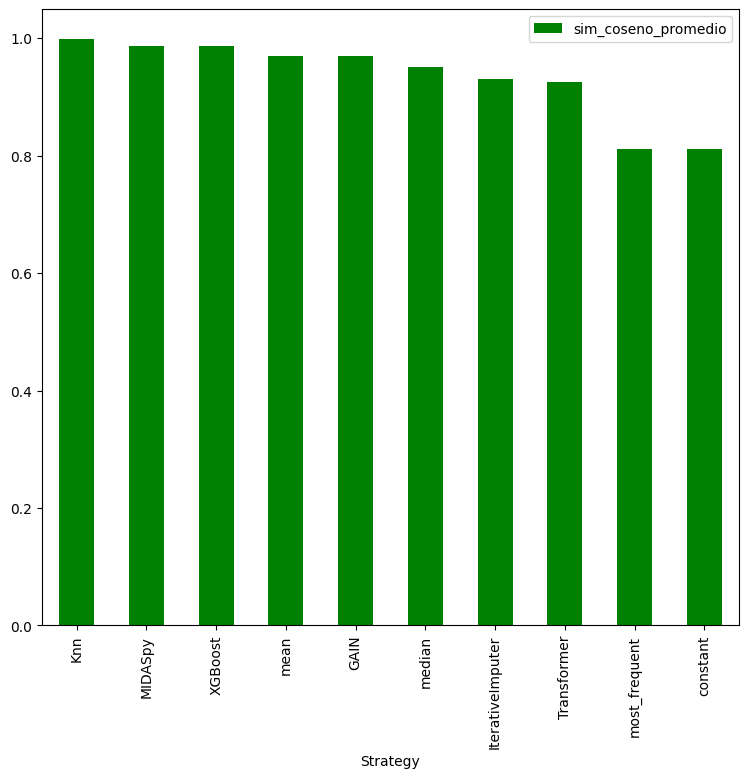

In [ ]:
df_resultados.sort_values(by=['sim_coseno_promedio'], ascending=False).plot(x='Strategy', y=["sim_coseno_promedio"], kind="bar", figsize=(9, 8), color='green')